In [1]:
# python required >= 3.5 version
import sys
assert sys.version_info >=(3,5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

import numpy as np
import os
import pandas as pd
# make the output satable accros run
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

ROOT = "."
chapter_id = "DNN"
image_path = os.path.join(ROOT,"images",chapter_id)
os.makedirs(image_path,exist_ok=True)

def save_fig(fig_id,tigh_layout=True,fig_extension="png",resolution=300):
    path = os.path.join(image_path,fig_id + "." + fig_extension)
    print("save figure ",fig_id)
    if tigh_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)


In [2]:
# get dataset fashion_mnist dataset
(X_train_full,y_train_full),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()
# standarisasi train data
X_train_full = X_train_full/255.0

# split train data to train and validasi data
X_valid,X_train = X_train_full[:5000], X_train_full[5000:]
y_valid,y_train = y_train_full[:5000], y_train_full[5000:]

# 1. Power scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [5]:
[i for i in dir(keras.initializers) if not i.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [6]:
optimizer = keras.optimizers.SGD(learning_rate=0.01,decay=1e-4)
model_1 = keras.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300,activation="selu",kernel_initializer="lecun_normal"),
    keras.layers.Dense(100,activation="selu",kernel_initializer="lecun_normal"),
    keras.layers.Dense(10,activation="softmax")
])
model_1.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

In [16]:
history_1 = model_1.fit(X_train,y_train,epochs=25,
                        validation_data=[X_valid,y_valid])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2966 - accuracy: 0.8952 - val_loss: 0.3363 - val_accuracy: 0.8806
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2956 - accuracy: 0.8953 - val_loss: 0.3310 - val_accuracy: 0.8802
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2951 - accuracy: 0.8955 - val_loss: 0.3311 - val_accuracy: 0.8778
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2944 - accuracy: 0.8959 - val_loss: 0.3318 - val_accuracy: 0.8804
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2935 - accuracy: 0.8953 - val_loss: 0.3305 - val_accuracy: 0.8808
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2927 - accuracy: 0.8963 - val_loss: 0.3297 - val_accuracy: 0.8814
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2917 - accuracy: 0.8967 - val_loss: 0.3296 - val_accuracy:

save figure  power_scheduling


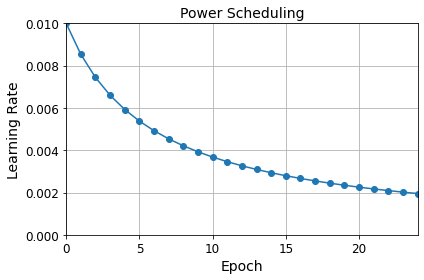

In [70]:
import math
n_epochs=25
learning_rate = 1e-2
decay = 1e-4
batch_size= 32
n_steps_per_epochs = math.ceil(len(X_train)/batch_size)#1719
epochs = np.arange(n_epochs)
lrs = learning_rate / (1+ decay * epochs * n_steps_per_epochs)

plt.plot(epochs,lrs,"o-")
plt.axis([0, n_epochs -1,   0, 1e-2])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
save_fig("power_scheduling")
plt.show()

# 2. Exponesial Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [20]:
# if setup initial learning rate and steps s rate static
def exponential_decay_fn(epoch):
    return 1e-2 * 1e-1 **(epoch/20)

In [29]:
# if want more dynamic allocation hyperparameter
def exponential_decay(lr0,s):
    def exponential_decay_fn(epoch):
        return lr0 * 1e-1 **(epoch/s)
    return exponential_decay_fn

In [30]:
exponential_decay_fn = exponential_decay(lr0=1e-2,s=20)
model_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model_2.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [31]:
lr_scheduler_exponensial = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history_2 = model_2.fit(X_train, y_train, epochs = n_epochs,
                        validation_data = [X_valid,y_valid],
                        callbacks=[lr_scheduler_exponensial])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7447 - accuracy: 0.7552 - val_loss: 0.5128 - val_accuracy: 0.8244 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5179 - accuracy: 0.8247 - val_loss: 0.4791 - val_accuracy: 0.8422 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4509 - accuracy: 0.8490 - val_loss: 0.3935 - val_accuracy: 0.8664 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4050 - accuracy: 0.8616 - val_loss: 0.4286 - val_accuracy: 0.8550 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3768 - accuracy: 0.8711 - val_loss: 0.4272 - val_accuracy: 0.8620 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3563 - accuracy: 0.8765 - val_loss: 0.4014 - val_accuracy: 0.8698 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 5s

In [37]:
history_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

save figure  Exponential Scheduling


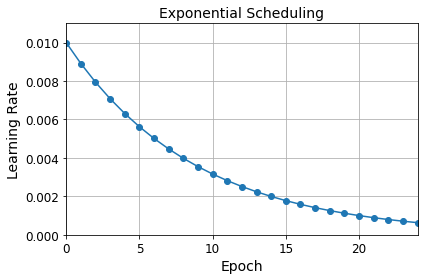

In [69]:
# exponensial scheduling per epochs
plt.plot(history_2.epoch, history_2.history["lr"],"o-")
plt.axis([0,n_epochs-1,  0,0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
save_fig("Exponential Scheduling")
plt.show()

In [40]:
# exponensial scheduling per iteration ( per batch)
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1/20)

In [42]:
K = keras.backend

class ExponensialDecay(keras.callbacks.Callback):
    def __init__(self,s=4e4):
        super().__init__()
        self.s = s
    
    def on_batch_begin(self,batch,logs=None):
        # Note : the batch argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr *0.1**(1/self.s))
    
    def on_epoch_end(self,epoch,logs=None):
        logs = logs or []
        logs["lr"] = K.get_value(self.model.optimizer.learning_rate)
        

In [46]:
model_3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 1e-2
optimizer = keras.optimizers.Nadam(learning_rate=lr0,beta_1=0.9,beta_2=0.999)
model_3.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
                metrics = ["accuracy"])
n_epochs = 25

s = 20 * len(X_train) //32 #=> 34375 number setiap steps pada 20 epochs(batch size =32) floor
exp_decay = ExponensialDecay(s)
history_3 = model_3.fit(X_train,y_train,epochs=n_epochs,
                        validation_data = [X_valid,y_valid],
                        callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7027 - accuracy: 0.7695 - val_loss: 0.8459 - val_accuracy: 0.7282 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5049 - accuracy: 0.8281 - val_loss: 0.4590 - val_accuracy: 0.8514 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4417 - accuracy: 0.8481 - val_loss: 0.5157 - val_accuracy: 0.8230 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3984 - accuracy: 0.8637 - val_loss: 0.5401 - val_accuracy: 0.8414 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3672 - accuracy: 0.8742 - val_loss: 0.3984 - val_accuracy: 0.8722 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3405 - accuracy: 0.8806 - val_loss: 0.3667 - val_accuracy: 0.8778 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 5s

In [49]:
# visualize
n_steps = n_epochs * len(X_train) //32 # 42968
steps = np.arange(n_steps)
lrs = lr0 * 0.1 **(steps / s)

save figure  Exponential Scheduling (per batch)


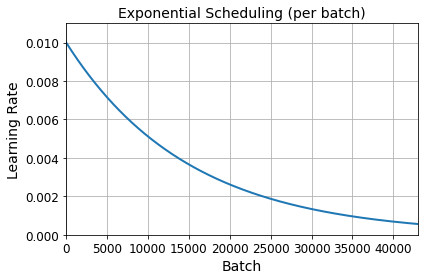

In [68]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
save_fig("Exponential Scheduling (per batch)")
plt.show()

# 3.Piecewise Constant Scheduling
Used the diferent learning on the initial learning rate and smaler learning rate then initial learning rate on many epochs 

In [56]:
def piecwise_constant_fn(epoch):
    if epoch < 5 :
        return 1e-2
    if epoch < 15:
        return 5e-3
    else:
        return 1e-3


In [62]:
def piecwise_constant_scheduling(boundaries,values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecwise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecwise_constant_fn
piecwise_constant_fn = piecwise_constant_scheduling([5,15],[1e-2,5e-3,1e-3])

In [58]:
np.array([0] + [5,15])

array([ 0,  5, 15])

In [63]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecwise_constant_fn)
model_4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model_4.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history_4 = model_4.fit(X_train,y_train,epochs=n_epochs,
                        validation_data = [X_valid,y_valid],
                        callbacks=[lr_scheduler])


Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7532 - accuracy: 0.7555 - val_loss: 0.8830 - val_accuracy: 0.7658 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5535 - accuracy: 0.8126 - val_loss: 0.4905 - val_accuracy: 0.8450 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4954 - accuracy: 0.8365 - val_loss: 0.4638 - val_accuracy: 0.8266 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4635 - accuracy: 0.8483 - val_loss: 0.5619 - val_accuracy: 0.8218 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4622 - accuracy: 0.8508 - val_loss: 0.4464 - val_accuracy: 0.8422 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3455 - accuracy: 0.8791 - val_loss: 0.4138 - val_accuracy: 0.8548 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 5s

save figure  Piecewise Constant Scheduling


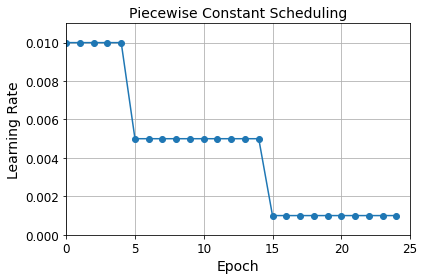

In [67]:
plt.plot(history_4.epoch,[piecwise_constant_fn(epoch) for epoch in history_4.epoch],"o-")
plt.axis([0,n_epochs,  0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
save_fig("Piecewise Constant Scheduling")
plt.show()

# 4. Performance Scheduling

In [71]:
tf.random.set_seed(42)
np.random.seed(42)

Patience :

Ketika Anda melatih sesuatu, itu dimulai dari kerugian tinggi dan selama pelatihan, kerugiannya turun dan turun (akurasi semakin tinggi).

Setelah beberapa epoch yang terbatas, loss yang cukup rendah tidak akan turun (akurasi tidak bertambah tinggi). Dalam situasi ini, tampaknya melatih lebih banyak epoch tidak berguna karena kereta Anda hampir selesai.

Sekarang pada saat ini, nilai kesabaran memberi tahu pelatih, berapa banyak epoch yang harus dilanjutkan setelah kerugian berhenti berkurang. Jika Anda tidak menetapkan nilai kesabaran, pelatihan akan berlanjut untuk semua epoch yang Anda tetapkan, bahkan jika hasil pelatihan Anda tidak membaik. Nilai ini menghemat waktu dan energi Anda (dengan mengistirahatkan GPU).

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience=5)